ray dir torch.Size([400, 3])
p torch.Size([400, 3])
r torch.Size([400, 3])


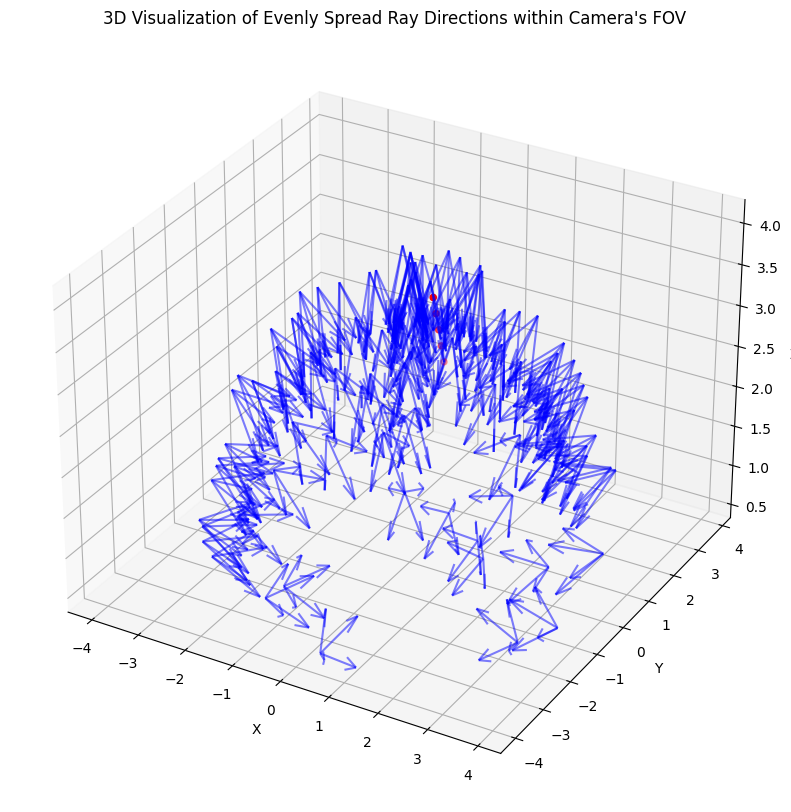

In [313]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def get_grid(sx, sy, sz, points_distance=0.5, info_size=3):
    
    grindx_indices,grindy_indices,grindz_indices = torch.arange(sx),torch.arange(sy),torch.arange(sz)

    coordsz, coordsx, coordsy = torch.meshgrid(grindz_indices,grindx_indices,grindy_indices, indexing='ij')

    # center grid
    coordsx, coordsy, coordsz = coordsx - np.ceil(sx/2) + 1, coordsy - np.ceil(sy/2) + 1, coordsz - np.ceil(sz/2) + 1

    # edit grid spacing
    coordsx, coordsy, coordsz = coordsx*points_distance, coordsy*points_distance, coordsz*points_distance
    
    # make it so no points of the grid are underground
    coordsz = coordsz - coordsz.min() 
    
    grid_grid = torch.stack([coordsx, coordsy, coordsz]).T
    grid_coords = grid_grid.reshape(sx*sy*sz,3)

    # grid_cells = torch.zeros([grid_coords.shape[0], info_size])
    grid_cells = torch.zeros_like(grid_grid)

    return grid_coords, grid_cells

def find_points_in_voxel(samples, points):
    # Assuming you have the following tensors
    num_samples = 100
    num_points = 64
    samples = torch.randn(num_samples, 3)  # Replace with your samples tensor
    points = torch.randn(num_points, 3)    # Replace with your points tensor

    # Determine the voxel size
    min_coords, _ = torch.min(points, dim=0)
    max_coords, _ = torch.max(points, dim=0)
    voxel_size = (max_coords - min_coords) / (num_points - 1)

    # Normalize the samples
    normalized_samples = (samples - min_coords) / voxel_size

    # Calculate the voxel indices for each sample
    voxel_indices = torch.floor(normalized_samples).long()

    # Find the unique voxel indices
    unique_voxel_indices = torch.unique(voxel_indices, dim=0)

    # Calculate the corner points of the voxels
    unique_corner_points = unique_voxel_indices * voxel_size + min_coords

    return unique_corner_points, unique_voxel_indices


def find_closest_points(samples, points, N):
    num_samples = samples.size(0)
    num_points = points.size(0)

    # Expand both tensors to calculate pairwise distances
    samples_exp = samples.unsqueeze(1).expand(-1, num_points, -1)
    points_exp = points.unsqueeze(0).expand(num_samples, -1, -1)

    # Compute squared Euclidean distances
    dists = torch.sum((samples_exp - points_exp)**2, dim=2)

    # Find the indices of the N closest points
    _, indices = torch.topk(dists, N, dim=1, largest=False)

    # Get the N closest points for each sample
    closest_points = points[indices]

    return closest_points, indices

def get_data_from_index(data, index):
    camera_angle_x = data["camera_angle_x"]
    frame = data["frames"][index]

    file_path = frame["file_path"]
    rotation = frame["rotation"]
    transform_matrix = torch.tensor(frame["transform_matrix"])

    return transform_matrix, rotation, file_path, camera_angle_x


def generate_rays(num_rays, transform_matrix, camera_angle_x, even_spread=False):

    # Extract camera axes and position
    camera_x_axis = transform_matrix[:3, 0]
    camera_y_axis = transform_matrix[:3, 1]
    camera_z_axis = -transform_matrix[:3, 2]

    # Compute the aspect ratio (width / height) of the camera's FOV
    aspect_ratio = camera_x_axis.norm() / camera_y_axis.norm()

    # Generate evenly spread ray indices
    if even_spread:
        num_rays_sqrt = np.round(np.sqrt(num_rays))
        
        u_values = torch.linspace(-0.5 * camera_angle_x, 0.5 * camera_angle_x, int(num_rays_sqrt))
        v_values = torch.linspace(-0.5 * camera_angle_x / aspect_ratio, 0.5 * camera_angle_x / aspect_ratio, int(num_rays_sqrt))
        ray_indices = torch.cartesian_prod(u_values, v_values)
        
    else:
        # Generate random ray indices
        ray_indices = torch.rand(num_rays, 2)  # Generate random numbers in the range [0, 1)

        # Scale and shift the ray indices to match the camera's FOV
        ray_indices[:, 0] = camera_angle_x * (ray_indices[:, 0] - 0.5)
        ray_indices[:, 1] = camera_angle_x / aspect_ratio * (ray_indices[:, 1] - 0.5)

    # Get the u and v values from ray_indices
    u_values, v_values = ray_indices[:, 0].unsqueeze(-1), ray_indices[:, 1].unsqueeze(-1)
    directions = u_values * camera_x_axis + v_values * camera_y_axis + camera_z_axis
    
    ray_directions = directions / directions.norm(dim=1).unsqueeze(-1)

    return ray_directions

def get_camera_normal(transform_matrix):
    fixed_pos = transform_matrix[:3, :3].unsqueeze(0)
    fixed_pos[:,2] = fixed_pos[:,2]* -1
    return fixed_pos

def visulize_rays(ray_directions, camera_positions):

    # Orthographic projection: discard the z-coordinate
    ray_directions_2d = ray_directions[:, :2]

    # Plot the 2D vectors
    plt.figure(figsize=(10, 10))
    origin_x = camera_positions[:, 0]
    origin_y = camera_positions[:, 1]

    plt.quiver(origin_x, origin_y,
                ray_directions_2d[:, 0], ray_directions_2d[:, 1], angles='xy', scale_units='xy',
               scale=1)
    # plt.xlim(-2, 2)
    # plt.ylim(-2, 2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.title("Orthographic Projection of Evenly Spread Ray Directions within Camera's FOV")
    plt.grid()
    plt.show()

def visualize_rays_3d(ray_directions, camera_positions, red=None, green=None, orange=None):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    origin_x = camera_positions[:, 0]
    origin_y = camera_positions[:, 1]
    origin_z = camera_positions[:, 2]

    # Plot 3D vectors
    for i in range(ray_directions.shape[0]):
        ax.quiver(origin_x[i], origin_y[i], origin_z[i],
                  ray_directions[i, 0], ray_directions[i, 1], ray_directions[i, 2],
                  color='b', alpha=0.5)

    for item, color in zip([red, green, orange], ['r','g','orange']):
        if not item is None:
            scatter_x = item[:, 0]
            scatter_y = item[:, 1]
            scatter_z = item[:, 2]
            ax.scatter(scatter_x, scatter_y, scatter_z, c=color, marker='o')
        

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title("3D Visualization of Evenly Spread Ray Directions within Camera's FOV")
    plt.show()

data_folder = "D:\9.programming\Plenoxels\data"
object_folders = ['chair', 'drums', 'ficus', 'hotdog', 'lego', 'materials', 'mic', 'ship']

with open(f"{data_folder}/{object_folders[0]}/transforms_train.json", "r") as f:
    data = json.load(f)

number_of_rays = 4
delta_step = 0.2
num_samples = 5

points_distance=1.2

ray_directions = torch.zeros([])
camera_positions = torch.zeros([])
for i in range(len(data["frames"])):
    transform_matrix, rotation, file_path, camera_angle_x = get_data_from_index(data, i)

    # current_ray_directions = transform_matrix[:3, 2].unsqueeze(0)* -1
    # camera_positions = transform_matrix[:3, 3].unsqueeze(0) if len(camera_positions.shape) == 0 else torch.cat([camera_positions, transform_matrix[:3, 3].unsqueeze(0)], 0)
    
    current_ray_directions = generate_rays(number_of_rays, transform_matrix, camera_angle_x, even_spread=True)
    ray_directions = current_ray_directions if len(ray_directions.shape) == 0 else torch.cat([ray_directions, current_ray_directions], 0)
    camera_positions = transform_matrix[:3, 3].unsqueeze(0).repeat(number_of_rays,1) if len(camera_positions.shape) == 0 else torch.cat([camera_positions, transform_matrix[:3, 3].unsqueeze(0).repeat(number_of_rays,1)], 0)

print(f"ray dir {ray_directions.shape}")
# samples = camera_positions + ray_directions*delta_step
delta_forsamples = (torch.repeat_interleave(torch.arange(num_samples + 1)[1:], camera_positions.shape[0])*delta_step).unsqueeze(1)
camera_positions_forsamples = torch.cat([camera_positions] * num_samples)
ray_directions_forsamples = torch.cat([ray_directions] * num_samples)
samples_interval = camera_positions_forsamples + ray_directions_forsamples*delta_forsamples

print("p",camera_positions.shape)
print("r",ray_directions.shape)

grid_indices, grid_cells = get_grid(9, 9, 9, points_distance=points_distance, info_size=4)
# closest_points, indices = find_closest_points(samples_interval, grid_indices, 8)
# closest_points, indices = find_points_in_voxel(samples_interval, grid_indices)

visualize_rays_3d(ray_directions, camera_positions, samples_interval[[i*number_of_rays*len(data["frames"]) for i in range(num_samples)]])
# visualize_rays_3d(ray_directions, camera_positions, grid_indices)
# visualize_rays_3d(ray_directions, camera_positions, closest_points[0,:])



In [271]:
# camera_positions_forsamples.shape
ray_directions_forsamples.shape
# delta_forsamples.shape
# num_samples*number_of_rays*len(data["frames"])

torch.Size([2000, 3])

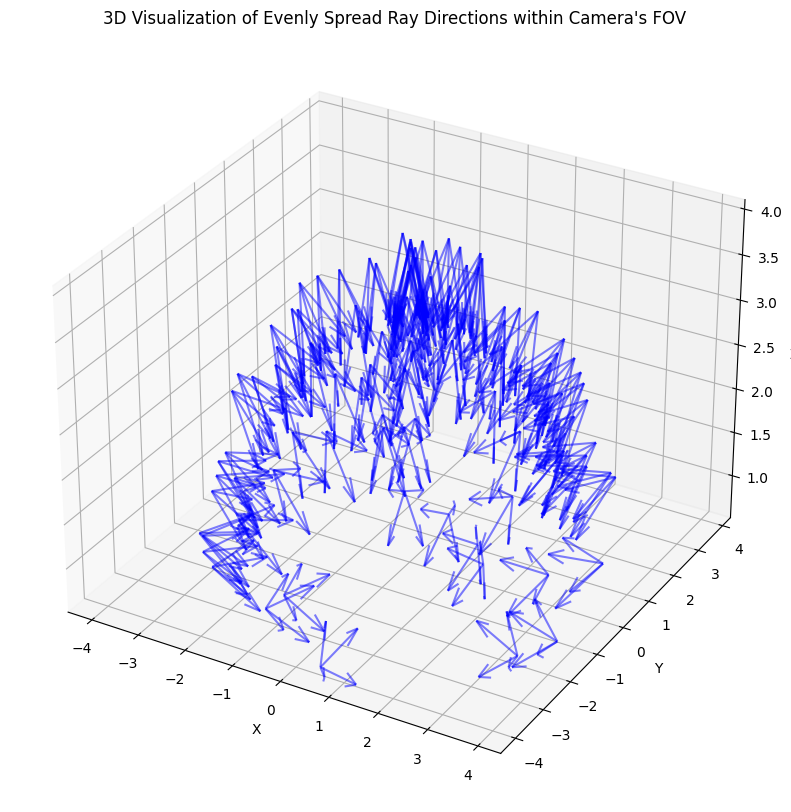

In [379]:
ray_directions = torch.zeros([])
camera_positions = torch.zeros([])
for i in range(len(data["frames"])):
    transform_matrix, rotation, file_path, camera_angle_x = get_data_from_index(data, i)

    current_ray_directions = transform_matrix[:3, 2].unsqueeze(0)* -1
    # camera_positions = transform_matrix[:3, 3].unsqueeze(0) if len(camera_positions.shape) == 0 else torch.cat([camera_positions, transform_matrix[:3, 3].unsqueeze(0)], 0)
    
    current_ray_directions = generate_rays(number_of_rays, transform_matrix, camera_angle_x, even_spread=True)
    ray_directions = current_ray_directions if len(ray_directions.shape) == 0 else torch.cat([ray_directions, current_ray_directions], 0)
    camera_positions = transform_matrix[:3, 3].unsqueeze(0) if len(camera_positions.shape) == 0 else torch.cat([camera_positions, transform_matrix[:3, 3].unsqueeze(0)], 0)


# samples = camera_positions + ray_directions*delta_step
delta_forsamples = torch.arange(num_samples + 1)[1:].repeat(number_of_rays*len(data["frames"])).unsqueeze(1)
camera_positions_forsamples = torch.repeat_interleave(camera_positions, num_samples*number_of_rays, 0)
ray_directions_forsamples = torch.repeat_interleave(ray_directions,num_samples, 0)
samples_interval = camera_positions_forsamples + ray_directions_forsamples*delta_forsamples

visualize_rays_3d(ray_directions, torch.repeat_interleave(camera_positions, number_of_rays, 0))


In [373]:
torch.repeat_interleave(camera_positions, number_of_rays,0).shape

torch.Size([400, 3])

In [222]:
# grid_cells.shape
# 


torch.Size([5200, 3])

In [153]:

# camera_positions
torch.cat([camera_positions] * num_samples)[:num_samples]

tensor([[-1.0572,  2.5740,  2.9166],
        [-1.0572,  2.5740,  2.9166],
        [-1.0572,  2.5740,  2.9166],
        [-1.0572,  2.5740,  2.9166],
        [ 0.2604, -0.2454,  4.0152]])

In [172]:
# for i in range(samples_interval.shape[0]):
#     print((samples_interval[i] - grid_indices.min(0)[0])*0.5)

(grid_indices - grid_indices.min(0)[0])/points_distance

normalized_samples_for_indecies = ((samples_interval - grid_indices.min(0)[0])/points_distance)
ceil_x = torch.ceil(normalized_samples_for_indecies[:,0]).unsqueeze(1)
ceil_y = torch.ceil(normalized_samples_for_indecies[:,1]).unsqueeze(1)
ceil_z = torch.ceil(normalized_samples_for_indecies[:,2]).unsqueeze(1)
floor_x = torch.floor(normalized_samples_for_indecies[:,0]).unsqueeze(1)
floor_y = torch.floor(normalized_samples_for_indecies[:,1]).unsqueeze(1)
floor_z = torch.floor(normalized_samples_for_indecies[:,2]).unsqueeze(1)

# generate the indecies of all the corners.
relevant_points = [
    torch.cat([x_component, y_component, z_component], 1).unsqueeze(1)
    for x_component in [ceil_x, floor_x]
    for y_component in [ceil_y, floor_y]
    for z_component in [ceil_z, floor_z]
]
relevant_points = torch.cat(relevant_points,1)

grid_indices.shape#[[relevant_points.type(torch.long)]]
# relevant_points[0]
# ceil_x
# normalized_samples_for_indecies[:,0].shape

# points_like = torch.arange(grid_cells.shape[0]).repeat([4,1]).T
# points_like[[[1,2,4,6]]]
# # points_like

tensor([[1, 1, 1, 1],
        [2, 2, 2, 2],
        [4, 4, 4, 4],
        [6, 6, 6, 6]])

torch.Size([729, 3])

In [121]:
print([25])
print(normalized_samples_for_indecies[25])

tensor([[8., 5., 1.],
        [8., 5., 0.],
        [8., 4., 1.],
        [8., 4., 0.],
        [7., 5., 1.],
        [7., 5., 0.],
        [7., 4., 1.],
        [7., 4., 0.]])
tensor([7.0778, 4.1469, 0.9011])


In [157]:
def get_grid(sx, sy, sz, points_distance=0.5, info_size=3):
    
    grindx_indices,grindy_indices,grindz_indices = torch.arange(sx),torch.arange(sy),torch.arange(sz)

    coordsz, coordsx, coordsy = torch.meshgrid(grindz_indices,grindx_indices,grindy_indices, indexing='ij')

    # center grid
    coordsx, coordsy, coordsz = coordsx - np.ceil(sx/2) + 1, coordsy - np.ceil(sy/2) + 1, coordsz - np.ceil(sz/2) + 1

    # edit grid spacing
    coordsx, coordsy, coordsz = coordsx*points_distance, coordsy*points_distance, coordsz*points_distance
    
    # make it so no points of the grid are underground
    coordsz = coordsz - coordsz.min() 
    
    grid_grid = torch.stack([coordsx, coordsy, coordsz]).T
    grid_coords = grid_grid.reshape(sx*sy*sz,3)

    grid_cells = torch.zeros([grid_coords.shape[0], info_size])

    return grid_coords, grid_cells

get_grid(3,3,3,0.5,9)

(tensor([[-0.5000, -0.5000,  0.0000],
         [-0.5000, -0.5000,  0.5000],
         [-0.5000, -0.5000,  1.0000],
         [ 0.0000, -0.5000,  0.0000],
         [ 0.0000, -0.5000,  0.5000],
         [ 0.0000, -0.5000,  1.0000],
         [ 0.5000, -0.5000,  0.0000],
         [ 0.5000, -0.5000,  0.5000],
         [ 0.5000, -0.5000,  1.0000],
         [-0.5000,  0.0000,  0.0000],
         [-0.5000,  0.0000,  0.5000],
         [-0.5000,  0.0000,  1.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.5000],
         [ 0.0000,  0.0000,  1.0000],
         [ 0.5000,  0.0000,  0.0000],
         [ 0.5000,  0.0000,  0.5000],
         [ 0.5000,  0.0000,  1.0000],
         [-0.5000,  0.5000,  0.0000],
         [-0.5000,  0.5000,  0.5000],
         [-0.5000,  0.5000,  1.0000],
         [ 0.0000,  0.5000,  0.0000],
         [ 0.0000,  0.5000,  0.5000],
         [ 0.0000,  0.5000,  1.0000],
         [ 0.5000,  0.5000,  0.0000],
         [ 0.5000,  0.5000,  0.5000],
         [ 0

TypeError: expected Tensor as element 0 in argument 0, but got int

In [478]:
# ray_directions 
# camera_positions
num_samples = 3
delta_step = 1.5
samples = camera_positions + ray_directions*delta_step
samples.shape# torch.arange(num_samples)*delta_step

torch.Size([1600, 3])

In [494]:
delta.shape

torch.Size([4800, 1])

In [536]:
delta_forsamples = (torch.repeat_interleave(torch.arange(num_samples), camera_positions.shape[0])*delta_step).unsqueeze(1)
camera_positions_forsamples = torch.cat([camera_positions] * num_samples)
ray_directions_forsamples = torch.cat([ray_directions] * num_samples)
samples_interval = camera_positions_forsamples + ray_directions_forsamples*delta_forsamples
samples_interval.shape

torch.Size([4800, 3])

In [535]:
(camera_positions_forsamples + ray_directions_forsamples*delta_forsamples)[[0,camera_positions.shape[0]]]
ray_directions_forsamples[1600]
ray_directions_forsamples[0]
delta_forsamples[1600]
# delta_forsamples[0]

tensor([1.5000])